<a href="https://colab.research.google.com/github/qarimbas/pytorch-deep-learning-course/blob/main/07_pytorch_experiment_tracking_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 07 PyTorch Experiment Tracking

import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3416, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 3416 (delta 47), reused 90 (delta 38), pack-reused 3302
Receiving objects: 100% (3416/3416), 643.45 MiB | 30.94 MiB/s, done.
Resolving deltas: 100% (1954/1954), done.
Updating files: 100% (222/222), done.


In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [6]:
set_seeds()

In [7]:
## 1. Get data

import os
import zipfile

from pathlib import Path

import requests

# example source: https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
  """Downloads a zipped dataset from source and unzips to destination."""

  #Setup path to data folder
  data_path = Path("data/")
  image_path = data_path / destination

  #If the image folder doesn't exist, create it
  if image_path.is_dir():
    print(f"[INFO] {image_path} directory already exists, skipping download.")
  else:
    print(f"[INFO] Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok = True)

    # Download the target data
    target_file = Path(source).name
    with open(data_path / target_file, "wb") as f:
      request = requests.get(source)
      print(f"[INFO] Downloading {target_file} from {source}...")
      f.write(request.content)
    
    # Unzip target file
    with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
      print(f"[INFO] Unzipping {target_file} data...")
      zip_ref.extractall(image_path)

    #Remove .zip file if needed
    if remove_source:
      os.remove(data_path / target_file)

  return image_path

In [8]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [9]:
## Create Datasets and DataLoaders

# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [10]:
# Setup ImageNet normalization levels
# See here: https://pytorch.org/vision/0.12/models.html 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
from torchvision import transforms
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])
print(f"Manually created transforms: {manual_transforms}")

# Create DataLoaders
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x7f521e47e280>,
 ['pizza', 'steak', 'sushi'])

In [11]:
from prompt_toolkit.styles.style_transformation import to_str
### 2.2 Create DataLoaders using automatically created transform

# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights (plenty of these weights available in torchvision.models v0.13+)
import torchvision
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT -> Best Available

# Get transforms from weights (these are the transforms used to train a particular or obtain a particular set of weights)
automatic_transforms = weights.transforms()
print(f"Automatically created transforms: {automatic_transforms}")

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=automatic_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x7f521e341550>,
 ['pizza', 'steak', 'sushi'])

In [12]:
## 3. Getting a pretrained model, freeze the base layers and change the classifier head

# Note: This is how a pretrained model would be created prior to torchvision v0.13+
#model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD

#Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights)
#model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [13]:
# Freeze all base layers by setting their requires_grad attribute to False
for param in model.features.parameters():
  #print(param)
  param.requires_grad = False

In [14]:
#Adjust the classifier head
set_seeds()
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))).to(device)

In [15]:
from torchinfo import summary

summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [16]:
## 4. Train a single model and track results

# Define a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Setup a SummaryWriter
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer

In [18]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

from going_modular.going_modular.engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # See SummaryWriter documentation
        writer.add_scalars(main_tag="Loss",
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)
        
        writer.add_scalars(main_tag="Accuracy",
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc},
                           global_step=epoch)
        
        writer.add_graph(model=model,
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))

    # Close the writer
    writer.close()
    ### End new ### 

    # Return the filled results at the end of the epochs
    return results

In [19]:
# Train model 
# Note: not using engine.train(), since we updated the train() function above
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0977 | train_acc: 0.3828 | test_loss: 0.8856 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9197 | train_acc: 0.6406 | test_loss: 0.8150 | test_acc: 0.7850
Epoch: 3 | train_loss: 0.7611 | train_acc: 0.8672 | test_loss: 0.6581 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.6884 | train_acc: 0.7695 | test_loss: 0.6214 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6468 | train_acc: 0.7969 | test_loss: 0.6053 | test_acc: 0.8665


In [20]:
## 5. View our model's results with TensorBoard

# Let's view our experiments from within the notebook
%load_ext tensorboard
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

In [21]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str = None):
  """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance tracking to a specific directory."""
  from datetime import datetime
  import os

  # Get timestamp of current date in reverse order
  timestamp = datetime.now().strftime("%Y-%m-%d") 

  if extra:
    # Create log directory path
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
  else:
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
  print(f"[INFO] Created SummaryWriter saving to {log_dir}")
  return SummaryWriter(log_dir=log_dir)

In [22]:
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")
example_writer

[INFO] Created SummaryWriter saving to runs/2023-01-22/data_10_percent/effnetb0/5_epochs


In [23]:
### 6.1 Update the `train()` function to include a writer parameter

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

from going_modular.going_modular.engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        if writer: 
          # See SummaryWriter documentation
          writer.add_scalars(main_tag="Loss",
                              tag_scalar_dict={"train_loss": train_loss,
                                              "test_loss": test_loss},
                              global_step=epoch)
          
          writer.add_scalars(main_tag="Accuracy",
                              tag_scalar_dict={"train_acc": train_acc,
                                              "test_acc": test_acc},
                              global_step=epoch)
          
          writer.add_graph(model=model,
                            input_to_model=torch.randn(32, 3, 224, 224).to(device))

          # Close the writer
          writer.close()
        
        else:
          pass
    ### End new ### 

    # Return the filled results at the end of the epochs
    return results



In [24]:
# 7 Setting up a series of modelling experiments

# 7.1 What kind of experiments should you run?

## 7.2 What experiments are we going to run?


### 7.3 Download different datasets

# Download 10 percent and 20 percent datasets
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory already exists, skipping download.
[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [25]:
## 7.4 Transform Datasets and Create Dataloaders

# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup the test directory
test_dir = data_10_percent_path / "test"

train_dir_10_percent, train_dir_20_percent, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [26]:
from torchvision import transforms

# Setup ImageNet normalization levels
# See here: https://pytorch.org/vision/0.12/models.html 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Compose transforms into a pipleine
simple_transform = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       normalize
])

In [27]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

# Create 20% training and test DataLoaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

print(f"Number of batches of size {BATCH_SIZE} in 10% train data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20% train data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 10% test data: {len(test_dataloader)}")
print(f"Class names: {class_names}")

Number of batches of size 32 in 10% train data: 8
Number of batches of size 32 in 20% train data: 15
Number of batches of size 32 in 10% test data: 3
Class names: ['pizza', 'steak', 'sushi']


In [28]:
### 7.5 Create feature extractor models

import torchvision

# Create an EffNetB2
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

effnetb2

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [29]:
summary(model=effnetb2,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [30]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
  # Get the weights and setup a model
  weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
  model = torchvision.models.efficientnet_b0(weights=weights).to(device)

  # Freeze the base model layers
  for param in model.features.parameters():
    param.requires_grad = False

  # Change the classifier head
  set_seeds()
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.2, inplace=True),
      nn.Linear(in_features=1280, out_features=OUT_FEATURES)
  ).to(device)

  # Give the model a name
  model.name = "effnetb0"
  print(f"[INFO] Created new {model.name} model...")
  return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
  # Get the weights and setup a model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  model = torchvision.models.efficientnet_b2(weights=weights).to(device)

  # Freeze the base model layers
  for param in model.features.parameters():
    param.requires_grad = False

  # Change the classifier head
  set_seeds()
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=OUT_FEATURES)
  ).to(device)

  # Give the model a name
  model.name = "effnetb2"
  print(f"[INFO] Created new {model.name} model...")
  return model

In [31]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [32]:
created_model_test_effnetb2 = create_effnetb2()
created_model_test_effnetb0 = create_effnetb0()

[INFO] Created new effnetb2 model...
[INFO] Created new effnetb0 model...


In [33]:
# Check out EffNetB2 feature extractor
summary(model=created_model_test_effnetb2,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [34]:
# Check out EffNetB0 feature extractor model
summary(model=created_model_test_effnetb0,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [35]:
### 7.6 Create experiments and set up training code

# Create epoch list
num_epochs = [5, 10]

# Create models list (need to create new model for each experiment)
models = ["effnetb0", "effnetb2"]

# Create a DataLoaders dictionary
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [37]:
%%time
from going_modular.going_modular.utils import save_model

# Set seeds
set_seeds(seed=42)

# Keep track of experiment numbers
experiment_number = 0

# Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():
  # Loop through the epochs
  for epochs in num_epochs:
    # Loop through each model name and create a new model instance
    for model_name in models:

      # Print out info
      experiment_number += 1
      print(f"[INFO] Experiment number: {experiment_number}")
      print(f"[INFO] Model: {model_name}")
      print(f"[INFO] DataLoader: {dataloader_name}")
      print(f"[INFO] Number of epochs: {epochs}")

      # Select and create the model
      if model_name == "effnetb0":
        model = create_effnetb0()
      else:
        model = create_effnetb2()
      
      # Create a new loss and optimizer for every model
      loss_fn = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

      # Train target model with target dataloader and track experiments 
      # Note: using train() rather than engine.train()
      train(model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=epochs,
            device=device,
            writer=create_writer(experiment_name=dataloader_name,
                                 model_name=model_name,
                                 extra=f"{epochs}_epochs"))
      
      # Save the model to file so we can import it later if need be
      save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
      save_model(model=model,
                 target_dir="models",
                 model_name=save_filepath)
      print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter saving to runs/2023-01-22/data_10_percent/effnetb0/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0551 | train_acc: 0.4727 | test_loss: 0.9023 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.9623 | train_acc: 0.5391 | test_loss: 0.8009 | test_acc: 0.7235
Epoch: 3 | train_loss: 0.7975 | train_acc: 0.7344 | test_loss: 0.7031 | test_acc: 0.8352
Epoch: 4 | train_loss: 0.7195 | train_acc: 0.7305 | test_loss: 0.5875 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6155 | train_acc: 0.8633 | test_loss: 0.5743 | test_acc: 0.8968
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter saving to runs/2023-01-22/data_10_percent/effnetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0891 | train_acc: 0.3398 | test_loss: 0.9470 | test_acc: 0.7102
Epoch: 2 | train_loss: 0.9269 | train_acc: 0.6523 | test_loss: 0.8774 | test_acc: 0.7235
Epoch: 3 | train_loss: 0.8390 | train_acc: 0.7070 | test_loss: 0.7530 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.7206 | train_acc: 0.7344 | test_loss: 0.7185 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.6544 | train_acc: 0.8125 | test_loss: 0.7206 | test_acc: 0.8769
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter saving to runs/2023-01-22/data_10_percent/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0551 | train_acc: 0.4727 | test_loss: 0.9023 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.9623 | train_acc: 0.5391 | test_loss: 0.8009 | test_acc: 0.7235
Epoch: 3 | train_loss: 0.7975 | train_acc: 0.7344 | test_loss: 0.7031 | test_acc: 0.8352
Epoch: 4 | train_loss: 0.7195 | train_acc: 0.7305 | test_loss: 0.5875 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6155 | train_acc: 0.8633 | test_loss: 0.5743 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.6368 | train_acc: 0.7461 | test_loss: 0.5820 | test_acc: 0.8968
Epoch: 7 | train_loss: 0.5914 | train_acc: 0.7773 | test_loss: 0.5011 | test_acc: 0.8864
Epoch: 8 | train_loss: 0.5181 | train_acc: 0.9336 | test_loss: 0.5006 | test_acc: 0.9072
Epoch: 9 | train_loss: 0.4902 | train_acc: 0.9180 | test_loss: 0.5368 | test_acc: 0.8352
Epoch: 10 | train_loss: 0.4684 | train_acc: 0.8984 | test_loss: 0.4970 | test_acc: 0.8968
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0891 | train_acc: 0.3398 | test_loss: 0.9470 | test_acc: 0.7102
Epoch: 2 | train_loss: 0.9269 | train_acc: 0.6523 | test_loss: 0.8774 | test_acc: 0.7235
Epoch: 3 | train_loss: 0.8390 | train_acc: 0.7070 | test_loss: 0.7530 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.7206 | train_acc: 0.7344 | test_loss: 0.7185 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.6544 | train_acc: 0.8125 | test_loss: 0.7206 | test_acc: 0.8769
Epoch: 6 | train_loss: 0.6021 | train_acc: 0.7969 | test_loss: 0.6902 | test_acc: 0.8769
Epoch: 7 | train_loss: 0.5785 | train_acc: 0.8047 | test_loss: 0.6362 | test_acc: 0.8466
Epoch: 8 | train_loss: 0.5145 | train_acc: 0.9375 | test_loss: 0.5894 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.5291 | train_acc: 0.8008 | test_loss: 0.5756 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.5212 | train_acc: 0.8164 | test_loss: 0.5746 | test_acc: 0.8873
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9653 | train_acc: 0.5646 | test_loss: 0.6636 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.7263 | train_acc: 0.7708 | test_loss: 0.5944 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.5619 | train_acc: 0.8313 | test_loss: 0.4737 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.5035 | train_acc: 0.8354 | test_loss: 0.4661 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4931 | train_acc: 0.8583 | test_loss: 0.4070 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter saving to runs/2023-01-22/data_20_percent/effnetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9881 | train_acc: 0.5167 | test_loss: 0.7968 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7439 | train_acc: 0.7917 | test_loss: 0.6647 | test_acc: 0.8769
Epoch: 3 | train_loss: 0.6461 | train_acc: 0.8125 | test_loss: 0.5793 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.5434 | train_acc: 0.8396 | test_loss: 0.5449 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4623 | train_acc: 0.8812 | test_loss: 0.4805 | test_acc: 0.9384
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter saving to runs/2023-01-22/data_20_percent/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9653 | train_acc: 0.5646 | test_loss: 0.6636 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.7263 | train_acc: 0.7708 | test_loss: 0.5944 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.5619 | train_acc: 0.8313 | test_loss: 0.4737 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.5035 | train_acc: 0.8354 | test_loss: 0.4661 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4931 | train_acc: 0.8583 | test_loss: 0.4070 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.4141 | train_acc: 0.8688 | test_loss: 0.4183 | test_acc: 0.9081
Epoch: 7 | train_loss: 0.3556 | train_acc: 0.9083 | test_loss: 0.3352 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.3458 | train_acc: 0.8771 | test_loss: 0.3086 | test_acc: 0.9072
Epoch: 9 | train_loss: 0.3790 | train_acc: 0.8750 | test_loss: 0.3418 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.3203 | train_acc: 0.9208 | test_loss: 0.2985 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9881 | train_acc: 0.5167 | test_loss: 0.7968 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7439 | train_acc: 0.7917 | test_loss: 0.6647 | test_acc: 0.8769
Epoch: 3 | train_loss: 0.6461 | train_acc: 0.8125 | test_loss: 0.5793 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.5434 | train_acc: 0.8396 | test_loss: 0.5449 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4623 | train_acc: 0.8812 | test_loss: 0.4805 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.4241 | train_acc: 0.8792 | test_loss: 0.4413 | test_acc: 0.9384
Epoch: 7 | train_loss: 0.3609 | train_acc: 0.9271 | test_loss: 0.4456 | test_acc: 0.8977
Epoch: 8 | train_loss: 0.3950 | train_acc: 0.8896 | test_loss: 0.4221 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.4103 | train_acc: 0.8604 | test_loss: 0.4049 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.3831 | train_acc: 0.8667 | test_loss: 0.4290 | test_acc: 0.8977
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

In [38]:
# Let's view our experiments within TensorBoard from within the notebook
%load_ext tensorboard
%tensorboard --logdir runs 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1337), started 1:03:40 ago. (Use '!kill 1337' to kill it.)

<IPython.core.display.Javascript object>

In [39]:

# # Upload the results to TensorBoard.dev (uncomment to try it out)
!tensorboard dev upload --logdir runs \
    --name "07. PyTorch Experiment Tracking: FoodVision Mini model result (video)" \
    --description "Comparing results of different model size, training data amount and training time."
    --one_shot

IndentationError: ignored

In [40]:

# Setup best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load in the saved state_dict())
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model...


<All keys matched successfully>

In [41]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert it to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


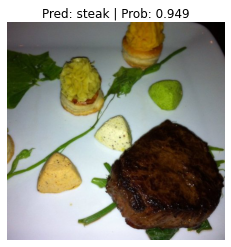

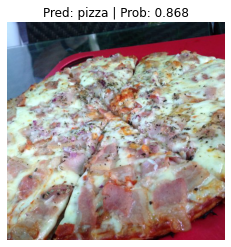

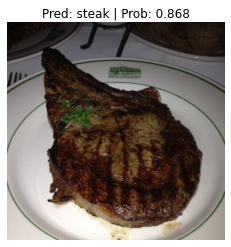

In [42]:
# Import function to make prediction on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Get a random list of 3 image path names from the test dataset
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list,
                                       k=num_images_to_plot)

for image_path in test_image_path_sample:
  pred_and_plot_image(model=best_model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224))

In [43]:
# Download custom image
import requests
from pathlib import Path

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

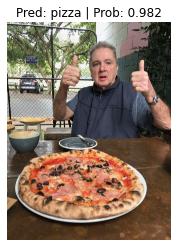

In [44]:

# Predict on our own custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)